# Markov Mixing Investigation in mHC

This notebook runs experiments to investigate whether doubly stochastic H_res matrices in mHC exhibit Markov chain mixing.

## Setup

In [1]:
# Clone the repository
# !git clone https://github.com/tokenbender/mHC-manifold-constrained-hyper-connections
!git clone https://github.com/pherber3/mHC-manifold-constrained-hyper-connections

Cloning into 'mHC-manifold-constrained-hyper-connections'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 251 (delta 93), reused 71 (delta 68), pack-reused 137 (from 1)
Receiving objects: 100% (251/251), 280.07 KiB | 8.75 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [2]:
!cd /content/mHC-manifold-constrained-hyper-connections && git pull

Already up to date.


In [3]:
# Install dependencies
%cd /content/mHC-manifold-constrained-hyper-connections
!pip install -e . --quiet
# !pip install -e ../.. --quiet
!pip install wandb --quiet

/content/mHC-manifold-constrained-hyper-connections
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.4/533.4 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 44.6 MB/s eta 0:00:00
  Building editable for mhc-hyper-connections (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.3.1 which is incompatible.


In [4]:
!python -c "from hyper_connections.hyper_connections import HyperConnections; hc = HyperConnections(4, dim=64, mhc=True); print('H_res_logits:', hc.H_res_logits)"

H_res_logits: Parameter containing:
tensor([[ 0., -2., -2., -2.],
        [-2.,  0., -2., -2.],
        [-2., -2.,  0., -2.],
        [-2., -2., -2.,  0.]], requires_grad=True)


In [5]:
# Verify GPU is available
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## Run Unit Tests

In [ ]:
# Run all Markov mixing tests
!pytest tests/test_markov_mixing.py -v

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/mHC-manifold-constrained-hyper-connections
configfile: pyproject.toml
plugins: langsmith-0.4.59, anyio-4.12.0, typeguard-4.4.4
collected 0 items                                                              

============================ no tests ran in 0.00s =============================
ERROR: file or directory not found: tests/test_markov_mixing.py



In [ ]:
# Run existing HC tests to make sure nothing broke
!pytest tests/test_hyper_connections.py -v

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/mHC-manifold-constrained-hyper-connections
configfile: pyproject.toml
plugins: langsmith-0.4.59, anyio-4.12.0, typeguard-4.4.4
collected 19 items                                                             

tests/test_hyper_connections.py::test_readme[False-1] PASSED             [  5%]
tests/test_hyper_connections.py::test_readme[False-4] PASSED             [ 10%]
tests/test_hyper_connections.py::test_readme[True-1] PASSED              [ 15%]
tests/test_hyper_connections.py::test_readme[True-4] PASSED              [ 21%]
tests/test_hyper_connections.py::test_manual PASSED                      [ 26%]
tests/test_hyper_connections.py::test_multi_input_hyper_connections[False] PASSED [ 31%]
tests/test_hyper_connections.py::test_multi_input_hyper_connections[True] PASSED [ 36%]
tests/test_

## Quick Sanity Check (No Training)

In [ ]:
# Test spectral analysis functions directly
import torch
from hyper_connections.hyper_connections import sinkhorn_log
from analysis.spectral import analyze_h_res, spectral_gap
from analysis.markov_metrics import cumulative_product_metrics

# Create some random H_res matrices
num_layers = 12
num_streams = 4

h_res_list = []
for i in range(num_layers):
    logits = torch.randn(num_streams, num_streams)
    H = sinkhorn_log(logits, num_iters=10, tau=0.05)
    h_res_list.append(H)

    props = analyze_h_res(H)
    print(f"Layer {i}: |λ₂|={props['lambda_2_abs']:.4f}, gap={props['spectral_gap']:.4f}")

print("\n--- Cumulative Product Analysis ---")
metrics = cumulative_product_metrics(h_res_list)
for i in range(len(metrics['dist_to_uniform'])):
    print(f"Depth {i}: dist_to_uniform={metrics['dist_to_uniform'][i]:.4f}, gap={metrics['spectral_gap'][i]:.4f}")

Layer 0: |λ₂|=0.7039, gap=0.2961
Layer 1: |λ₂|=0.9251, gap=0.0749
Layer 2: |λ₂|=0.9619, gap=0.0381
Layer 3: |λ₂|=0.9995, gap=0.0005
Layer 4: |λ₂|=0.9967, gap=0.0033
Layer 5: |λ₂|=0.8765, gap=0.1235
Layer 6: |λ₂|=0.9484, gap=0.0516
Layer 7: |λ₂|=0.9997, gap=0.0003
Layer 8: |λ₂|=0.3848, gap=0.6152
Layer 9: |λ₂|=0.9867, gap=0.0133
Layer 10: |λ₂|=0.6885, gap=0.3115
Layer 11: |λ₂|=0.8894, gap=0.1106

--- Cumulative Product Analysis ---
Depth 0: dist_to_uniform=1.4381, gap=0.2961
Depth 1: dist_to_uniform=1.2807, gap=0.1908
Depth 2: dist_to_uniform=1.2085, gap=0.2471
Depth 3: dist_to_uniform=1.0939, gap=0.2537
Depth 4: dist_to_uniform=1.0095, gap=0.5378
Depth 5: dist_to_uniform=0.6725, gap=0.7614
Depth 6: dist_to_uniform=0.5197, gap=0.8630
Depth 7: dist_to_uniform=0.5257, gap=0.6510
Depth 8: dist_to_uniform=0.5521, gap=0.8400
Depth 9: dist_to_uniform=0.5623, gap=0.8638
Depth 10: dist_to_uniform=0.5983, gap=0.8925
Depth 11: dist_to_uniform=0.2824, gap=0.8979


## Download FineWeb10B Data

In [6]:
%cd examples/nanogpt
!python data/fineweb10B/download.py

/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt
  - 1 validation shard
  - 9 training shards

  downloading fineweb_val_000000.bin...
fineweb_val_000000.bin: 100% 200M/200M [00:02<00:00, 93.0MB/s] 
  downloading fineweb_train_000001.bin...
fineweb_train_000001.bin: 100% 200M/200M [00:01<00:00, 143MB/s]
  downloading fineweb_train_000002.bin...
fineweb_train_000002.bin: 100% 200M/200M [00:03<00:00, 57.0MB/s]
  downloading fineweb_train_000003.bin...
fineweb_train_000003.bin: 100% 200M/200M [00:01<00:00, 129MB/s]
  downloading fineweb_train_000004.bin...
fineweb_train_000004.bin: 100% 200M/200M [00:01<00:00, 113MB/s]
  downloading fineweb_train_000005.bin...
fineweb_train_000005.bin: 100% 200M/200M [00:02<00:00, 85.1MB/s]
  downloading fineweb_train_000006.bin...
fineweb_train_000006.bin: 100% 200M/200M [00:02<00:00, 83.5MB/s] 
  downloading fineweb_train_000007.bin...
fineweb_train_000007.bin: 100% 200M/200M [00:05<00:00, 37.5MB/s]
  downloading fineweb_train_000008

## Phase 1: Baseline Characterization

Train a 6-layer mHC model to establish baseline spectral properties.

In [ ]:
# Optional: Login to W&B
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:


KeyboardInterrupt: 

In [18]:
# !rm -rf /content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/out-mhc-baseline-test

In [19]:
# Train 6-layer mHC baseline (quick test - 500 iters)
!python train.py config/train_fineweb10B_mhc.py \
    max_iters=500 \
    eval_interval=100 \
    sinkhorn_tau=1.0 \
    spectral_log_interval=100 \
    out_dir="out-mhc-baseline-test"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 3
wandb: You chose "Don't visualize my results"
w

In [20]:
# Analyze the checkpoint
!python /content/mHC-manifold-constrained-hyper-connections/scripts/analyze_checkpoint.py --checkpoint out-mhc-baseline-test/ckpt.pt

Analyzing checkpoint: out-mhc-baseline-test/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 12
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 0.9414
  Spectral gap (1 - |λ₂|): 0.0586

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 0.3934
  Mixing ratio (final/initial): 0.2272
  Max spectral gap (cumulative): 0.9501

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✗ Mixing ratio < 0.5: Cumulative product converging to uniform



In [23]:
from hyper_connections.hyper_connections import sinkhorn_log

# Load checkpoint
ckpt = torch.load("/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/out-mhc-baseline-test/ckpt.pt", map_location="cpu", weights_only=False)
state_dict = ckpt["model"]

# Find all H_res_logits keys
h_res_keys = sorted([k for k in state_dict if "H_res_logits" in k])

print(f"Found {len(h_res_keys)} H_res_logits tensors")

for key in h_res_keys:
    logits = state_dict[key]
    H = sinkhorn_log(logits, num_iters=10, tau=0.05)

    print(f"\n{key}:")
    print(f"  Logits:\n{logits}")
    print(f"  H_res (after Sinkhorn):\n{H}")
    print(f"  Off-diagonal sample: {logits[0, 1].item():.4f}")

Found 12 H_res_logits tensors

transformer.h.0.hc_attn.H_res_logits:
  Logits:
tensor([[ 0.0171, -2.0157, -2.0065, -2.0174],
        [-2.0157,  0.0171, -2.0065, -2.0174],
        [-2.0154, -2.0154,  0.0370, -2.0146],
        [-2.0005, -2.0005, -1.9917,  0.0186]])
  H_res (after Sinkhorn):
tensor([[1.0000e+00, 2.2054e-18, 2.6479e-18, 2.1322e-18],
        [2.2054e-18, 1.0000e+00, 2.6479e-18, 2.1322e-18],
        [1.4888e-18, 1.4888e-18, 1.0000e+00, 1.5132e-18],
        [2.9032e-18, 2.9032e-18, 3.4589e-18, 1.0000e+00]])
  Off-diagonal sample: -2.0157

transformer.h.0.hc_mlp.H_res_logits:
  Logits:
tensor([[ 1.3492, -0.2775,  0.1495, -8.2114],
        [-0.2775,  1.3492,  0.1495, -8.2114],
        [-8.4817, -8.4817,  7.9600, -8.9883],
        [-4.7173, -4.7173, -3.8848,  3.9359]])
  H_res (after Sinkhorn):
tensor([[1.0000e+00, 7.4175e-15, 3.7951e-11, 0.0000e+00],
        [7.4175e-15, 1.0000e+00, 3.7951e-11, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.00

## Full Training Run (6-layer baseline)

In [ ]:
# Full 5000 iteration training
!python train.py config/train_fineweb10B_mhc.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run

In [ ]:
# Analyze the trained checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-fineweb10B-mhc/ckpt.pt \
    --output ../../analysis_results/baseline_6l

Analyzing checkpoint: out-fineweb10B-mhc/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 12
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 1.0000
  Spectral gap (1 - |λ₂|): 0.0000

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 1.7321
  Mixing ratio (final/initial): 1.0000
  Max spectral gap (cumulative): 0.0000

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✓ Mixing ratio > 0.8: Staying far from uniform

Results saved to: ../../analysis_results/baseline_6l/mixing_analysis.json


## Residual-Only Ablation

Test whether H_pre/H_post injections compensate for mixing.

In [ ]:
# Train residual-only variant
!python train.py config/train_fineweb10B_mhc_resonly.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run

In [ ]:
# Analyze residual-only checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-fineweb10B-mhc-resonly/ckpt.pt \
    --output ../../analysis_results/resonly_6l

Analyzing checkpoint: out-fineweb10B-mhc-resonly/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 12
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 1.0000
  Spectral gap (1 - |λ₂|): 0.0000

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 1.7321
  Mixing ratio (final/initial): 1.0000
  Max spectral gap (cumulative): 0.0000

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✓ Mixing ratio > 0.8: Staying far from uniform

Results saved to: ../../analysis_results/resonly_6l/mixing_analysis.json


## 48-Layer Deep Model

In [29]:
# Train 48-layer mHC
!python train.py config/train_fineweb10B_mhc_48l.py max_iters=500 eval_interval=100 sinkhorn_tau=1.0 out_dir="out-mhc-48l-test"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 32,768
  model params: 20,779,350

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: wandb_v1_2KROf8xpaUbSCBUFyHjEqwcpzqn_Nks6jDkyc5iID

In [31]:
!python /content/mHC-manifold-constrained-hyper-connections/scripts/analyze_checkpoint.py --checkpoint out-mhc-48l-test/ckpt.pt

Analyzing checkpoint: out-mhc-48l-test/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 96
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 0.8905
  Spectral gap (1 - |λ₂|): 0.1095

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 0.6074
  Mixing ratio (final/initial): 0.3507
  Max spectral gap (cumulative): 1.0000

------------------------------------------------------------
INTERPRETATION:
  ⚠ Per-layer |λ₂| in [0.7, 0.9]: Moderate mixing
    Some mixing occurs but may not accumulate severely.
  ✗ Mixing ratio < 0.5: Cumulative product converging to uniform



In [37]:
!python train.py config/train_fineweb10B_mhc_48l.py \
    max_iters=500 \
    eval_interval=100 \
    sinkhorn_tau=0.05 \
    out_dir="out-mhc-48l-old"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 32,768
  model params: 20,779,350

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ Waiting for wan

In [44]:
!python train.py config/train_fineweb10B_48l.py max_iters=500 eval_interval=100 out_dir="out-baseline-48l-test"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 32,768
  model params: 20,673,750

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ Waiting for wan

## Compare Sinkhorn vs Orthostochastic

In [ ]:
# Train with orthostochastic projection
!python train.py config/train_fineweb10B_mhc.py \
    mhc_h_res_proj="orthostochastic" \
    out_dir="out-mhc-orthostochastic" \
    wandb_run_name="mhc-orthostochastic"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Traceback (most recent call last):
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/train.py", line 304, in <module>
    model = GPT(model_config)
            ^^^^^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/model.

In [ ]:
# Analyze orthostochastic checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-mhc-orthostochastic/ckpt.pt \
    --projection orthostochastic \
    --output ../../analysis_results/orthostochastic_6l

Analyzing checkpoint: out-mhc-orthostochastic/ckpt.pt
Projection method: orthostochastic
Traceback (most recent call last):
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 245, in <module>
    sys.exit(main())
             ^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 207, in main
    results = run_analysis(
              ^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 73, in run_analysis
    ckpt = load_checkpoint(checkpoint_path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 28, in load_checkpoint
    return torch.load(path, map_location="cpu", weights_only=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

## Custom Analysis

Run analysis directly in Python for more control.

In [32]:
import sys
sys.path.insert(0, '../..')

import re
import torch
import matplotlib.pyplot as plt
from hyper_connections.hyper_connections import sinkhorn_log
from analysis.spectral import analyze_h_res
from analysis.markov_metrics import cumulative_product_metrics

def natural_sort_key(s):
    """Sort strings with embedded numbers naturally (e.g., h.2 before h.10)."""
    return [int(x) if x.isdigit() else x for x in re.split(r'(\d+)', s)]

def load_and_analyze(checkpoint_path, tau=1.0):
    """Load checkpoint and run full analysis."""
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    state_dict = ckpt['model']

    # Extract H_res matrices, separating attn and mlp (with natural sorting)
    h_res_keys = sorted([k for k in state_dict if 'H_res_logits' in k], key=natural_sort_key)

    attn_layers = {}
    mlp_layers = {}
    h_res_list = []

    for key in h_res_keys:
        logits = state_dict[key]
        H = sinkhorn_log(logits, 10, tau)
        h_res_list.append(H)

        # Parse layer index from key like "transformer.h.0.hc_attn.H_res_logits"
        parts = key.split('.')
        layer_idx = int(parts[2])  # transformer.h.{idx}

        analysis = analyze_h_res(H)

        if 'hc_attn' in key:
            attn_layers[layer_idx] = {'H': H, **analysis}
        else:
            mlp_layers[layer_idx] = {'H': H, **analysis}

    cumulative = cumulative_product_metrics(h_res_list)

    return attn_layers, mlp_layers, cumulative, h_res_list

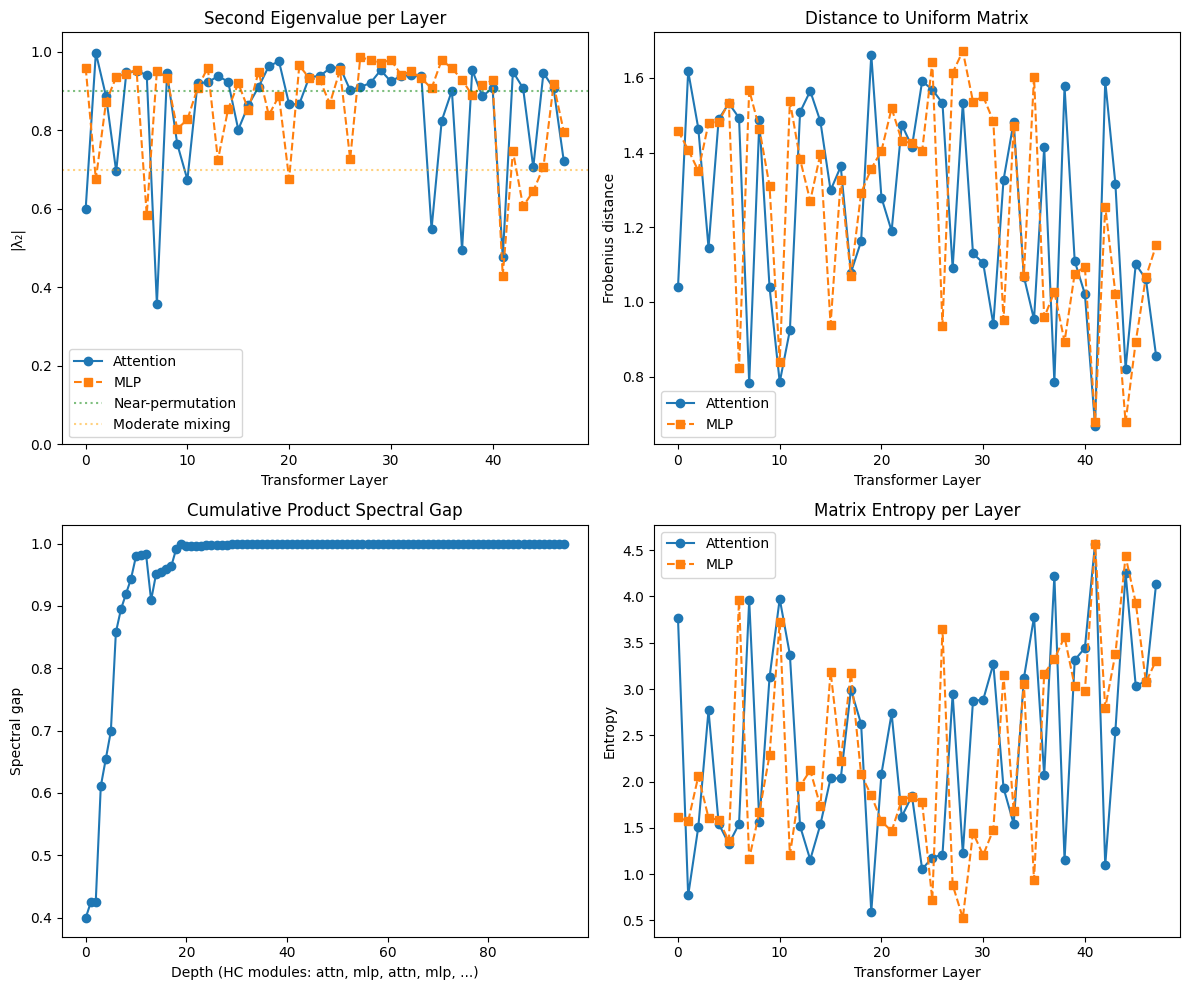

In [41]:
def plot_mixing_analysis(attn_layers, mlp_layers, cumulative):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    layers = sorted(attn_layers.keys())

    # Per-layer |λ₂| - separate lines for attn and mlp
    ax = axes[0, 0]
    attn_lambda2 = [attn_layers[i]['lambda_2_abs'] for i in layers]
    mlp_lambda2 = [mlp_layers[i]['lambda_2_abs'] for i in layers]
    ax.plot(layers, attn_lambda2, 'o-', label='Attention')
    ax.plot(layers, mlp_lambda2, 's--', label='MLP')
    ax.axhline(y=0.9, color='g', linestyle=':', alpha=0.5, label='Near-permutation')
    ax.axhline(y=0.7, color='orange', linestyle=':', alpha=0.5, label='Moderate mixing')
    ax.set_xlabel('Transformer Layer')
    ax.set_ylabel('|λ₂|')
    ax.set_title('Second Eigenvalue per Layer')
    ax.legend()
    ax.set_ylim(0, 1.05)

    # Distance to uniform - separate lines
    ax = axes[0, 1]
    attn_dist = [attn_layers[i]['dist_to_uniform'] for i in layers]
    mlp_dist = [mlp_layers[i]['dist_to_uniform'] for i in layers]
    ax.plot(layers, attn_dist, 'o-', label='Attention')
    ax.plot(layers, mlp_dist, 's--', label='MLP')
    ax.set_xlabel('Transformer Layer')
    ax.set_ylabel('Frobenius distance')
    ax.set_title('Distance to Uniform Matrix')
    ax.legend()

    # Cumulative spectral gap (this stays as-is, sequential)
    ax = axes[1, 0]
    ax.plot(cumulative['spectral_gap'], 'o-')
    ax.set_xlabel('Depth (HC modules: attn, mlp, attn, mlp, ...)')
    ax.set_ylabel('Spectral gap')
    ax.set_title('Cumulative Product Spectral Gap')

    # Per-layer entropy - separate lines
    ax = axes[1, 1]
    attn_ent = [attn_layers[i]['entropy'] for i in layers]
    mlp_ent = [mlp_layers[i]['entropy'] for i in layers]
    ax.plot(layers, attn_ent, 'o-', label='Attention')
    ax.plot(layers, mlp_ent, 's--', label='MLP')
    ax.set_xlabel('Transformer Layer')
    ax.set_ylabel('Entropy')
    ax.set_title('Matrix Entropy per Layer')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training):
attn_layers, mlp_layers, cumulative, h_res_list = load_and_analyze('out-mhc-48l-test/ckpt.pt')
plot_mixing_analysis(attn_layers, mlp_layers, cumulative)

## Visualize H_res Matrices

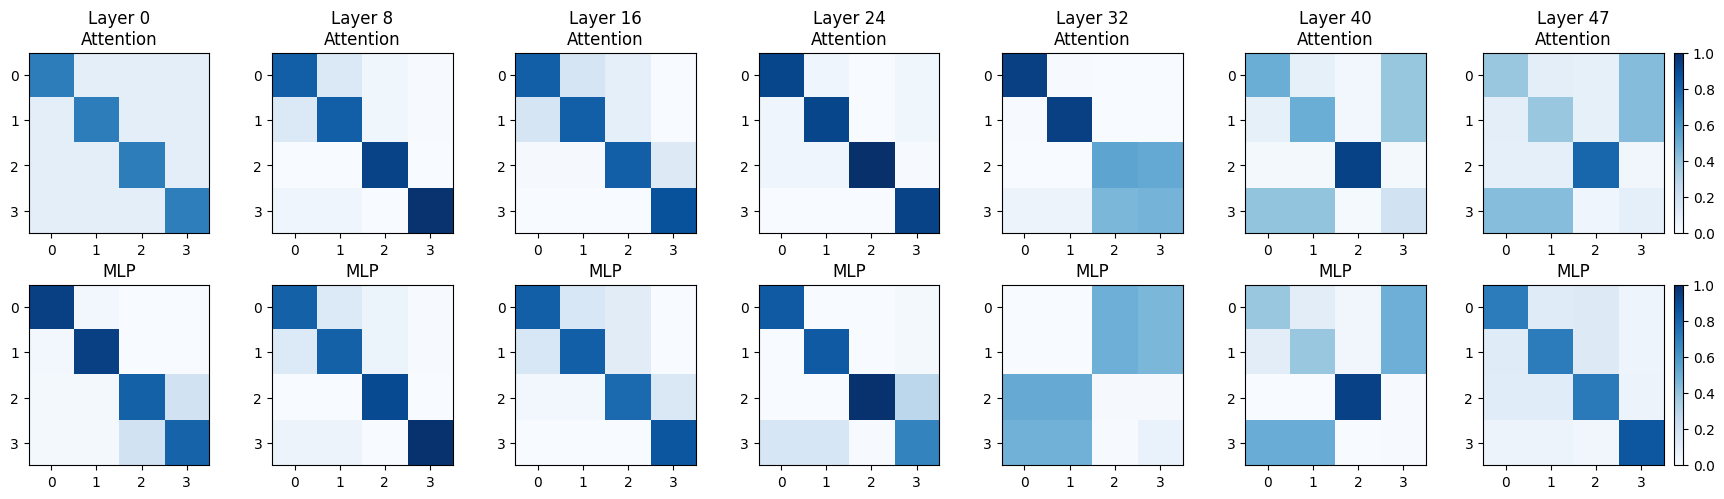

In [42]:
def plot_h_res_heatmaps(attn_layers, mlp_layers, step=1):
    """Visualize H_res matrices as heatmaps - attn on top row, mlp on bottom.

    Args:
        attn_layers: dict of attention layer data
        mlp_layers: dict of mlp layer data
        step: show every Nth layer (always includes first and last)
    """
    all_layers = sorted(attn_layers.keys())

    # Always include first and last, then fill in with step
    if len(all_layers) <= 2:
        layers = all_layers
    else:
        first, last = all_layers[0], all_layers[-1]
        middle = [l for l in all_layers[1:-1] if (l - first) % step == 0]
        layers = [first] + middle + [last]

    n_layers = len(layers)

    fig, axes = plt.subplots(2, n_layers, figsize=(2.5*n_layers, 5))

    # Handle single column case
    if n_layers == 1:
        axes = axes.reshape(2, 1)

    for col, layer_idx in enumerate(layers):
        # Attention row
        ax = axes[0, col]
        H = attn_layers[layer_idx]['H'].numpy()
        im = ax.imshow(H, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'Layer {layer_idx}\nAttention')
        ax.set_xticks(range(H.shape[0]))
        ax.set_yticks(range(H.shape[0]))
        if col == n_layers - 1:
            plt.colorbar(im, ax=ax, fraction=0.046)

        # MLP row
        ax = axes[1, col]
        H = mlp_layers[layer_idx]['H'].numpy()
        im = ax.imshow(H, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'MLP')
        ax.set_xticks(range(H.shape[0]))
        ax.set_yticks(range(H.shape[0]))
        if col == n_layers - 1:
            plt.colorbar(im, ax=ax, fraction=0.046)

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training):
plot_h_res_heatmaps(attn_layers, mlp_layers, step=8)

In [1]:
def get_cumulative_products(h_res_list):
    """Return list of cumulative H_res products."""
    products = []
    n = h_res_list[0].shape[0]
    product = torch.eye(n, device=h_res_list[0].device)

    for H in h_res_list:
        product = H @ product
        products.append(product.clone())

    return products

def plot_cumulative_heatmaps(h_res_list, step=None, depths=None):
    """Visualize cumulative H_res products as heatmaps.

    Args:
        h_res_list: list of H_res matrices in layer order
        step: show every Nth depth (always includes first and last)
        depths: explicit list of depths to show (1-indexed, e.g., [1, 6, 12, 24, 48, 96])
                If provided, step is ignored.
    """
    cumulative = get_cumulative_products(h_res_list)
    n_total = len(cumulative)

    if depths is not None:
        # Convert 1-indexed depths to 0-indexed, filter valid ones
        depth_indices = [d - 1 for d in depths if 1 <= d <= n_total]
    elif step is not None:
        # Always include first and last, then fill in with step
        all_depths = list(range(n_total))
        if n_total <= 2:
            depth_indices = all_depths
        else:
            first, last = 0, n_total - 1
            middle = [d for d in all_depths[1:-1] if d % step == 0]
            depth_indices = [first] + middle + [last]
    else:
        # Default: show first and last
        depth_indices = [0, n_total - 1]

    n_plots = len(depth_indices)
    fig, axes = plt.subplots(1, n_plots, figsize=(2.5*n_plots, 2.5))

    if n_plots == 1:
        axes = [axes]

    for col, depth in enumerate(depth_indices):
        ax = axes[col]
        P = cumulative[depth].numpy()
        im = ax.imshow(P, cmap='Blues', vmin=0, vmax=P.max())
        ax.set_title(f'∏H_res\n(1→{depth+1})')
        ax.set_xticks(range(P.shape[0]))
        ax.set_yticks(range(P.shape[0]))

        # Add value annotations
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                ax.text(j, i, f'{P[i,j]:.2f}', ha='center', va='center',
                       fontsize=8, color='white' if P[i,j] > 0.5 else 'black')

        if col == n_plots - 1:
            plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle('Cumulative H_res Products')
    plt.tight_layout()
    plt.show()

# Usage:
# plot_cumulative_heatmaps(h_res_list, step=12)
# Or:
plot_cumulative_heatmaps(h_res_list, depths=[1, 6, 12, 24, 48, 96])

NameError: name 'h_res_list' is not defined

## Compare Multiple Checkpoints

In [ ]:
def compare_checkpoints(checkpoint_paths, labels):
    """Compare mixing behavior across multiple checkpoints."""
    results = {}
    for path, label in zip(checkpoint_paths, labels):
        try:
            per_layer, cumulative, _ = load_and_analyze(path)
            results[label] = {
                'per_layer': per_layer,
                'cumulative': cumulative
            }
        except FileNotFoundError:
            print(f"Checkpoint not found: {path}")

    if not results:
        print("No checkpoints found!")
        return

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Compare cumulative distance to uniform
    ax = axes[0]
    for label, data in results.items():
        ax.plot(data['cumulative']['dist_to_uniform'], 'o-', label=label)
    ax.set_xlabel('Depth')
    ax.set_ylabel('Distance to Uniform')
    ax.set_title('Cumulative Mixing Comparison')
    ax.legend()

    # Compare avg |λ₂| per layer
    ax = axes[1]
    for label, data in results.items():
        lambda2s = [data['per_layer'][i]['lambda_2_abs']
                    for i in sorted(data['per_layer'].keys())]
        ax.plot(lambda2s, 'o-', label=label)
    ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('|λ₂|')
    ax.set_title('Per-Layer Second Eigenvalue')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training multiple models):
# compare_checkpoints(
#     ['out-fineweb10B-mhc/ckpt.pt', 'out-fineweb10B-mhc-48l/ckpt.pt'],
#     ['6-layer', '48-layer']
# )

In [36]:
import torch
import re

ckpt = torch.load('out-mhc-48l-test/ckpt.pt', map_location='cpu', weights_only=False)
state_dict = ckpt['model']

def natural_sort_key(s):
    return [int(x) if x.isdigit() else x for x in re.split(r'(\d+)', s)]

h_res_keys = sorted([k for k in state_dict if 'H_res_logits' in k], key=natural_sort_key)
print(f'Found {len(h_res_keys)} H_res_logits')

# Check first and last few
for i, key in enumerate(h_res_keys[:3] + h_res_keys[-3:]):
    logits = state_dict[key]
    print(f'\n{key}:')
    print(f'  diagonal mean: {logits.diag().mean():.4f}')
    print(f'  off-diag mean: {logits[~torch.eye(4, dtype=bool)].mean():.4f}')
    print(f'  off-diag max:  {logits[~torch.eye(4, dtype=bool)].max():.4f}')
    print(f'  off-diag min:  {logits[~torch.eye(4, dtype=bool)].min():.4f}')

Found 96 H_res_logits

transformer.h.0.hc_attn.H_res_logits:
  diagonal mean: -0.0417
  off-diag mean: -1.9871
  off-diag max:  -1.9810
  off-diag min:  -1.9927

transformer.h.0.hc_mlp.H_res_logits:
  diagonal mean: 1.9849
  off-diag mean: -2.6595
  off-diag max:  0.3281
  off-diag min:  -5.5619

transformer.h.1.hc_attn.H_res_logits:
  diagonal mean: 3.1232
  off-diag mean: -3.3043
  off-diag max:  0.8205
  off-diag min:  -5.3556

transformer.h.46.hc_mlp.H_res_logits:
  diagonal mean: -0.8156
  off-diag mean: -2.2555
  off-diag max:  0.6203
  off-diag min:  -5.4729

transformer.h.47.hc_attn.H_res_logits:
  diagonal mean: -0.7485
  off-diag mean: -1.6520
  off-diag max:  -0.3741
  off-diag min:  -2.4641

transformer.h.47.hc_mlp.H_res_logits:
  diagonal mean: 0.1789
  off-diag mean: -2.0777
  off-diag max:  -1.3065
  off-diag min:  -2.4684
